In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore")

# Initial Steps

### Loading Data and inspection

In [2]:
df = pd.read_csv("data_transformed.csv")
df_copy = df

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59916 entries, 0 to 59915
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               59916 non-null  object 
 1   Bedrooms               59916 non-null  int64  
 2   Bathrooms              59916 non-null  int64  
 3   Type                   59916 non-null  object 
 4   Stratum                59916 non-null  float64
 5   Area_transformed_log   59913 non-null  float64
 6   Price_transformed_log  59916 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 3.2+ MB


* Stratum and Type must be labeled as category in the pipeline process.
* The rest of data are fine.

### Data elimination

In [4]:
df.drop(columns = ['Bedrooms', 'Bathrooms', 'Stratum', 'Location' ], inplace = True)

In [5]:
df['Type'] = df['Type'].astype('category')

In [6]:
df.dropna(inplace = True)

* Bedrooms and Bathrooms were dropped because as stated in the EDA those features aren't relevant for the Clustering process.
* Nevertheless, Location and Stratum are important, but they were also eliminated because they are less critical than the price, and also to avoid the known "curse of dimensionality".  

# Clustering Model Design and Elaboration

### General Idea and Design

Following the good practices stated in the sklearn documentation, and also to avoid common mistakes, the pipeline must have these features:

1. Divide data in train and validation parts. Even this is a usupervised learning task, is always a good practice to reserve a portion of your data to validate your analysis. 
2. Transform correctly categorical and numerical data. RobustScaler was selected because is solid against Outliers, and OnehotEnconding because is the first option with categorical data that doesn't have any target (if this was the case TargetEncoder could have been a good choice). 

Therefore, the first steps of the model elaboration were:

In [7]:
# Step 0: Train/Validation Split
df_train, df_val = train_test_split(df, test_size = 0.2, random_state = 42)

# Step 1: Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include = ['object', 'category']).columns.tolist()  
numerical_cols = df.select_dtypes(include = ['float64', "int64"]).columns.tolist()  

# Step 2: Preprocessing data according to the type
preprocessor = ColumnTransformer(
    transformers = [
        ('cat', OneHotEncoder(drop = 'first'), categorical_cols), 
        ('num', RobustScaler(), numerical_cols)])

### Selection of Clustering Algorithm

There are three situations to keep in mind before selecting the Algorithm:

1. Dataset is large.
2. Model will be run in a CPU.
3. Must be solid against outliers, even after transformation of Data.

Therefore, following the documentation section of clustering in sklearn, BIRCH algorithm was selected to be included in the pipeline. Keep in mind that general purposes algorithms like K-means could have been used too.

In [ ]:
# Step 3: Define Pipeline with Preprocessing and Birch
pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('birch', Birch())  
])

### BIRCH model tuning and validation 

Because there isn't a feature to be predicted to be compared, Silhouette score was used to evaluate the clustering method. 

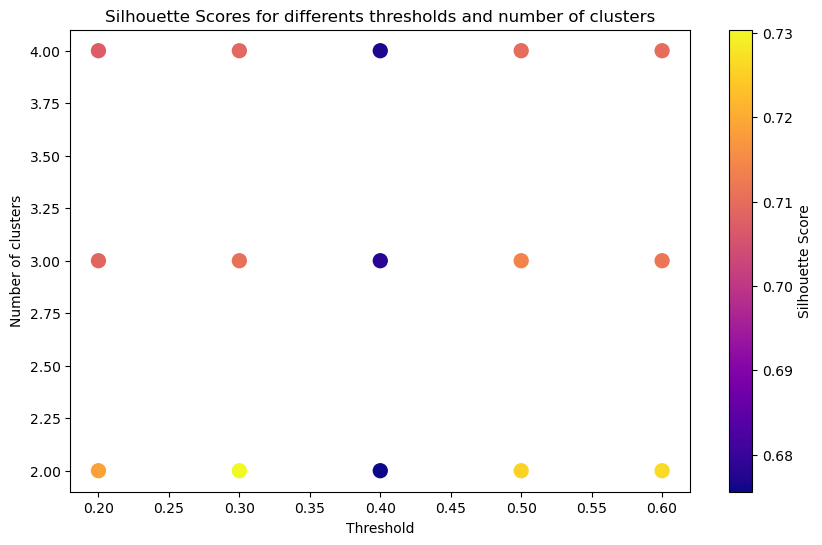

In [79]:
# Step 4: Apply different values for threshold and n_clusters and evaluate with Silhouette Score
threshold_values = np.linspace(0.2, 0.6, 5)  
n_clusters_values = [2,3,4]                 

# Initialize a list to store silhouette scores
silhouette_avg = []

# Loop through combinations of threshold and n_clusters
for threshold in threshold_values:
    for n_clusters in n_clusters_values:
        
        # Update Birch with the current hyperparameters
        pipeline.set_params(birch__threshold=threshold, birch__n_clusters=n_clusters)
        pipeline.fit(df_train)
        
        # Preprocess validation data
        df_val_preprocessed = pipeline.named_steps['preprocessor'].transform(df_val)
        
        # Predict cluster labels on the validation set
        cluster_labels = pipeline.named_steps['birch'].predict(df_val_preprocessed)
        
        # Check if there are valid clusters
        if len(set(cluster_labels)) > 1:  # Check if more than one cluster exists
            # Calculate silhouette score
            score = silhouette_score(df_val_preprocessed, cluster_labels)
            silhouette_avg.append((threshold, n_clusters, score))
        else:
            silhouette_avg.append((threshold, n_clusters, -1))  # Append -1 for no valid clusters

# Step 5: Plot Silhouette Scores
threshold_vals, n_clusters_vals, scores = zip(*silhouette_avg)
plt.figure(figsize = (10, 6))
plt.scatter(threshold_vals, n_clusters_vals, c = scores, cmap ='plasma', s = 100)
plt.colorbar(label ='Silhouette Score')
plt.xlabel('Threshold')
plt.ylabel('Number of clusters')
plt.title('Silhouette Scores for differents thresholds and number of clusters')
plt.show()

Thereshold number of 0.3 gave the best result. Hence model was run again with this fixed value to find the optimal number of clusters. 

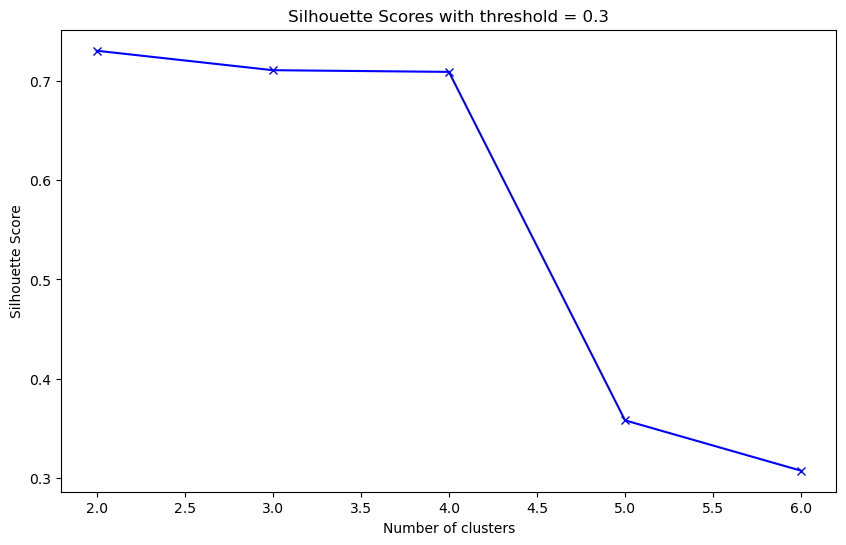

In [77]:
# Step 6 : Define Pipeline with thershold = 3
pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('birch', Birch(threshold = 0.3))  
])

# Step 7: Loop through different values of n_clusters 
n_clusters_values = [2, 3, 4, 5, 6]  

# Initialize a list to store silhouette scores
silhouette_avg = []

# Loop through n_clusters values
for n_clusters in n_clusters_values:
    # Update Birch with the current number of clusters
    pipeline.set_params(birch__n_clusters = n_clusters)
    
    # Fit the pipeline on the training data
    pipeline.fit(df_train)
    
    # Preprocess validation data
    df_val_preprocessed = pipeline.named_steps['preprocessor'].transform(df_val)
    
    # Predict cluster labels on the validation set
    cluster_labels = pipeline.named_steps['birch'].predict(df_val_preprocessed)
    
    # Check if there are valid clusters
    if len(set(cluster_labels)) > 1:  # Check if more than one cluster exists
        # Calculate silhouette score 
        score = silhouette_score(df_val_preprocessed, cluster_labels)
        silhouette_avg.append((n_clusters, score))
    else:
        silhouette_avg.append((n_clusters, -1))  # Append -1 for no valid clusters

# Step 8: Plot Silhouette Scores 
n_clusters_vals, scores = zip(*silhouette_avg)
plt.figure(figsize = (10, 6))
plt.plot(n_clusters_vals, scores, 'bx-', label ='Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores with threshold = 0.3')
plt.show()

A number of clusters between 2 and 4 gave good results, with a silhouette score above 0.7. Therefore the model was run one more time with 4 clusters and then it was labeled the data according to the results. 

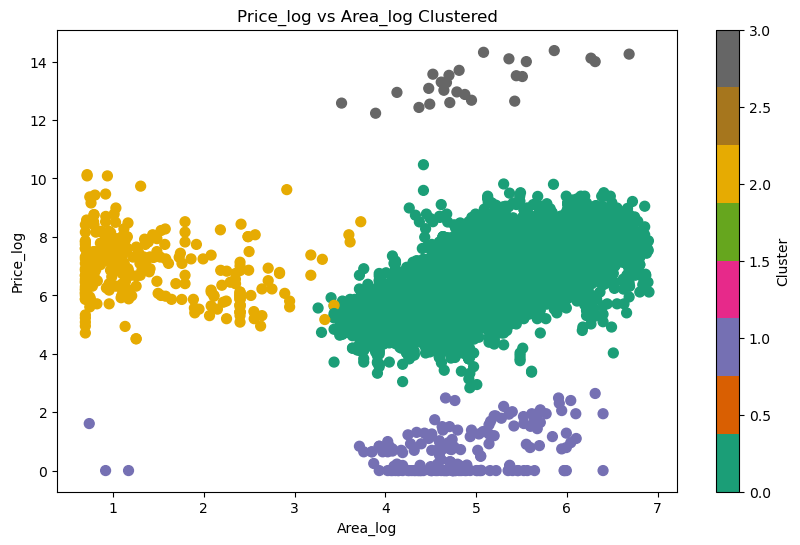

In [87]:
# Step 9: Define Pipeline with fixed numbers
pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('birch', Birch(threshold = 0.3, n_clusters = 4))  
])

# Step 10: Fit the model
pipeline.fit(df_train)

# Step 11: Apply the transformation and predict cluster labels on the full dataset
df_preprocessed = pipeline.named_steps['preprocessor'].transform(df)
cluster_labels = pipeline.named_steps['birch'].predict(df_preprocessed)

# Step 12: Add the cluster labels to the dataframe
df['Cluster'] = cluster_labels

# Step 13: Scatter plot of Price_log vs Area_log colored by cluster
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['Area_transformed_log'], df['Price_transformed_log'], c = df['Cluster'], cmap = 'Dark2', s = 50)
plt.colorbar(scatter, label ='Cluster')
plt.xlabel('Area_log')
plt.ylabel('Price_log')
plt.title('Price_log vs Area_log Clustered')
plt.show()

# Conclusions

This study provides a general methodology of a EDA/ML process, from obtaining the data till the model elaboration and tuning. Some other steps that can be used to improve the previous process are:

* Using dimensional reduction techniques like PCA.
* Obtain more data for other websites, like https://www.metrocuadrado.com/ or https://www.ciencuadras.com/.
* Test other algorithms like HDBSCAN or Affinity Propagation.

Also, is possible to use the data for regression or classification tasks, but is adviced to get more data and features from other places, also with information related to the cities like population or average income. 

# Acknowledgements

* Ben Postance. His post inspired me and gave me ideas to make this study. You can find his work in https://bpostance.github.io/posts/clustering-mixed-data/.
* Oak Academy.Their heart attack study gave me a guide on how to structure this study. You can find their work in https://www.kaggle.com/code/oaktechacademy/up-to-date-heart-attack-analysis-and-prediction.

# References

* https://camacol.co/prensa/noticias/tras-caida-en-el-pib-de-edificaciones-y-los-indicadores-de-vivienda-camacol-insiste
* https://www.dane.gov.co/index.php/servicios-al-ciudadano/servicios-informacion/estratificacion-socioeconomica
* https://www.portafolio.co/economia/finanzas/eliminar-los-estratos-en-colombia-implicaciones-en-el-ciudadano-y-posturas-de-expertos-599570
* https://scikit-learn.org/stable/common_pitfalls.html
* https://scikit-learn.org/stable/modules/clustering.html#